In [2]:
import catboost as cb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn as sk

In [3]:
dataset = "../data/engineered-dataset.csv"
df = pd.read_csv(dataset, index_col=None, thousands=',')

In [4]:
df.describe()

,Imps,Viewable Imps,Clicks,Dsp Total Cost USD,Dsp Media Cost USD,Ssp Media Cost USD,Pc Convs,Total Convs,Adstxt Verified Imps,Day of week,Hour of day,VerifiedImpRate,ConvPerVerImp,SspCostPerConv,DspTotalCostPerConv,DspTotalCostPerVerImp,ConversionsPerUSD,VerImpPerUSD
count,79065.000000,79065.000000,79065.000000,79065.000000,79065.000000,79065.000000,79065.000000,79065.000000,79065.000000,79065.000000,79065.000000,79065.000000,72975.000000,11459.000000,11459.000000,72975.000000,79065.000000,79065.000000
mean,939.322836,511.779473,1.468539,2.252957,1.855104,1.424515,0.074470,2.276393,499.851173,2.979321,11.411902,0.757925,0.046960,1.204550,1.996512,0.052469,1.659759,371.501003
std,3589.117932,2151.531299,6.794143,6.757863,5.543096,4.235450,0.923525,22.476481,1997.382888,1.993029,6.507527,0.330714,0.516723,3.075539,5.439712,0.140171,11.205250,1088.234413
min,1.000000,0.000000,0.000000,0.200000,0.010000,0.010000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.001951,0.002520,0.000041,0.000000,0.000000
25%,13.000000,0.000000,0.000000,0.310000,0.250000,0.190000,0.000000,0.000000,7.000000,1.000000,6.000000,0.577381,0.000000,0.090000,0.133000,0.002530,0.000000,13.745704
50%,82.000000,0.000000,0.000000,0.550000,0.450000,0.350000,0.000000,0.000000,46.000000,3.000000,12.000000,0.972365,0.000000,0.312500,0.470000,0.016154,0.000000,47.349823
75%,346.000000,99.000000,0.000000,1.580000,1.310000,1.020000,0.000000,0.000000,236.000000,5.000000,17.000000,1.000000,0.000000,1.070000,1.635000,0.055000,0.000000,359.090909
max,159220.000000,93776.000000,320.000000,405.370000,365.640000,292.510000,44.000000,1222.000000,108361.000000,6.000000,23.000000,1.000000,61.000000,86.670000,180.870000,18.060000,396.774194,24584.000000


# Target = verified impressions

### Data selection

In [5]:
df_brand_b = df.loc[df["Advertiser"] == "Brand B"]

features = df_brand_b[["Day of week", "Hour of day", "Publisher", "Campaign", "VerifiedImpRate"]]

target = df_brand_b[["ConversionsPerUSD"]]

X_train, X_val, y_train, y_val = sk.model_selection.train_test_split(features, target, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = sk.model_selection.train_test_split(X_val, y_val, test_size=0.5, random_state=42)

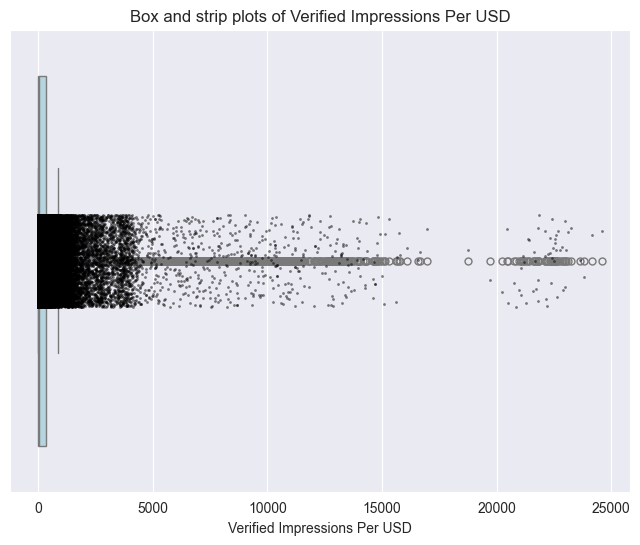

In [6]:
plt.figure(figsize=(8, 6))
sns.boxplot(x=df["VerImpPerUSD"], color="lightblue", fliersize=5)

sns.stripplot(
    x=df["VerImpPerUSD"],  # switch out for conv...
    color="black",
    size=2,
    alpha=0.5,
    jitter=True
)

plt.title("Box and strip plots of Verified Impressions Per USD")
plt.xlabel("Verified Impressions Per USD")

# Show the plot
plt.show()

### Fit model

In [7]:
model = cb.CatBoostRegressor(
    loss_function="RMSE",
    eval_metric="RMSE",
    early_stopping_rounds=15,
    boosting_type="Ordered",
    random_seed=42,
    task_type="GPU",
    logging_level="Silent",
    leaf_estimation_method="Gradient"
)

model.fit(
    X_train,
    y_train,
    cat_features=[0, 1, 2, 3],
    eval_set=[(X_val, y_val)],
)

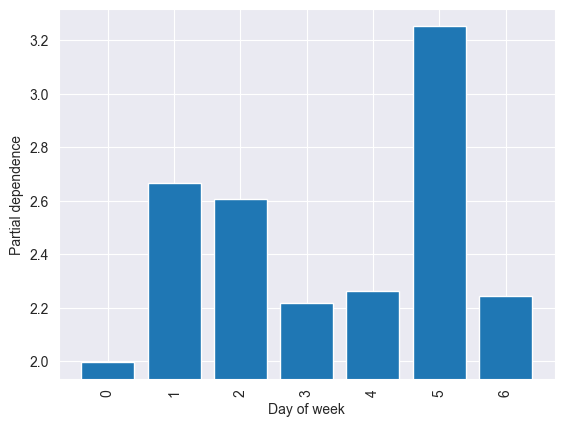

In [8]:
from sklearn.inspection import PartialDependenceDisplay

PartialDependenceDisplay.from_estimator(
    model, X_train, features=["Day of week"], kind="average", categorical_features=[0],
)

In [9]:
# sklearn comparison
# est = HistGradientBoostingRegressor(categorical_features=[0, 1, 2, 3]).fit(X_train, y_train.to_numpy().ravel())
# y_test_pred = est.predict(X_test)

In [10]:
# baseline mean prediction
# y_test_pred = np.full_like(y_test, y_test.to_numpy().mean())

### Eval

In [11]:
y_test_pred = model.predict(X_test)

mae, rmse = sk.metrics.mean_absolute_error(y_test, y_test_pred), sk.metrics.root_mean_squared_error(y_test, y_test_pred)
print(mae, rmse)
print(target.mean(), target.std())

1.6146318474532453 6.954973908549482
ConversionsPerUSD    2.472357
dtype: float64 ConversionsPerUSD    13.63316
dtype: float64


### Visualise true-pred

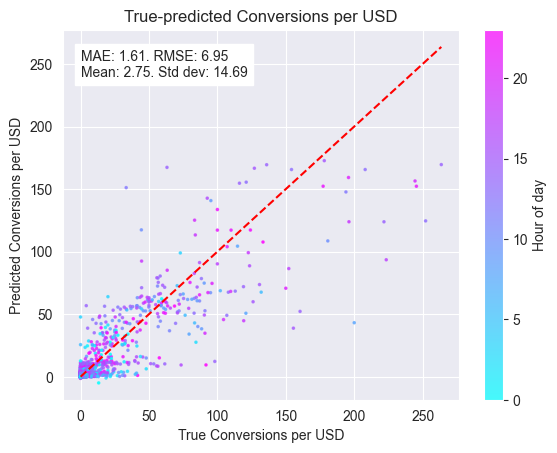

In [12]:
fig, ax = plt.subplots()
scatter = ax.scatter(y_test,
                     y_test_pred,
                     s=2.5, alpha=0.7,
                     c=X_test["Hour of day"],
                     cmap="cool",
                     vmin=np.min(X_test["Hour of day"]),
                     vmax=np.max(X_test["Hour of day"]))

fig.colorbar(scatter, label="Hour of day")

line = ax.plot([np.min(y_test), np.max(y_test)],
               [np.min(y_test), np.max(y_test)],
               color='red', linestyle='--')

plt.ylabel("Predicted Conversions per USD")
plt.xlabel("True Conversions per USD")
plt.text(0, 240, f"MAE: {mae:.2f}. RMSE: {rmse:.2f}\n"
                 f"Mean: {y_test.to_numpy().mean():.2f}. Std dev: {y_test.to_numpy().std():.2f}",
         bbox=dict(facecolor='white', alpha=1))

plt.title("True-predicted Conversions per USD")

plt.show()

### Feature importance

In [13]:
model.get_feature_importance(prettified=True)


,Feature Id,Importances
0,Campaign,56.784082
1,Publisher,22.009020
2,VerifiedImpRate,8.687315
3,Hour of day,7.107798
4,Day of week,5.411785
